# **Importing relevant packages**

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import boxcox, zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (silhouette_score, roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve,auc)

# **Tutoring Website Data**

In [217]:
file = r'C:\Users\durga\OneDrive\Desktop\hanuman\Tutoring Dataset.csv'
df = pd.read_csv(file)
df.head()

,User_ID,Age_in_Months,Gender,Location,Grade,Logins_per_Month,Days_Completed_Activity,Exercises_Started,Total_Time_Spent_in_Minutes,Course_Name,...,Recommendation_Likelihood,Exercises_Completed,Points_Earned,Subscription_Tier,Subscription_Cost,Subscription_Length_in_Months,Renewal_Status,Tutoring,Referrals,Academic_Grade
0,654b113d-4ce4-41a9-a8f4-7f1419419230,156,Other,"Smithchester, VA",8th Grade,6,5,9.784359,107.889381,Chemistry,...,3,7,1910.292936,Free,0.00,4,Yes,Yes,0,D
1,2a044973-1d29-4b2f-83f6-c488290140bb,202,Female,"Beckside, FL",10th Grade,6,6,9.000000,198.865171,Web Development,...,4,9,1698.767255,Free,0.00,1,Yes,No,0,F
2,d84bb18b-bd77-4be9-98bb-a0993b95af75,173,Other,"New Deborahborough, SD",9th Grade,7,4,12.159345,232.639784,Geometry,...,4,10,1860.295769,Premium,9.99,13,Yes,No,0,D
3,411cebf6-18cc-4846-89c7-f3f7bcaede01,199,Female,"West Stephanie, KY",12th Grade,17,17,28.000000,506.644691,Pre-Calculus,...,3,28,4465.824908,Basic,5.99,11,Yes,No,1,F
4,e4ada708-10b6-4fcd-ac08-a83152658751,148,Female,"West Roberthaven, LA",7th Grade,10,8,15.458939,305.275706,Java Programming,...,4,17,2499.211664,Premium,9.99,12,Yes,No,0,F


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14843 entries, 0 to 14842
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   User_ID                        14843 non-null  object 
 1   Age_in_Months                  14843 non-null  int64  
 2   Gender                         14843 non-null  object 
 3   Location                       14843 non-null  object 
 4   Grade                          14843 non-null  object 
 5   Logins_per_Month               14843 non-null  int64  
 6   Days_Completed_Activity        14843 non-null  int64  
 7   Exercises_Started              14843 non-null  float64
 8   Total_Time_Spent_in_Minutes    14843 non-null  float64
 9   Course_Name                    14843 non-null  object 
 10  Course_Category                14843 non-null  object 
 11  Completion_Rate                14843 non-null  float64
 12  Average_Score                  14843 non-null 

# **Removing Freemium Users**

In [220]:
df = df[df['Subscription_Tier'] != 'Free']

# **Feature Engineering**

In [222]:
df.groupby('Course_Rating')[['Points_Earned','Days_Completed_Activity','Subscription_Length_in_Months','Age_in_Months','Exercises_Completed',
        'Logins_per_Month','Total_Time_Spent_in_Minutes','Completion_Rate','Exercises_Started','Average_Score']].mean().T

Course_Rating,3,4,5
Points_Earned,2216.040782,2367.871832,2514.593051
Days_Completed_Activity,7.766917,8.575891,9.347826
Subscription_Length_in_Months,8.349624,8.345629,8.512516
Age_in_Months,175.451128,176.739758,179.554677
Exercises_Completed,11.687970,13.276409,14.592885
Logins_per_Month,8.195489,9.073458,9.781291
Total_Time_Spent_in_Minutes,271.734565,316.620892,352.771869
Completion_Rate,71.271063,71.753540,71.870362
Exercises_Started,14.527116,15.986967,17.406680
Average_Score,75.595516,76.639403,77.364696


# Inferential Statistical Analysis

In [224]:
data_3 = df[df['Course_Rating'] == 3]['Points_Earned']
data_4 = df[df['Course_Rating'] == 4]['Points_Earned']
data_5 = df[df['Course_Rating'] == 5]['Points_Earned']

# Perform Welch's t-tests for each pair (unequal variance)
t_test_3_4 = stats.ttest_ind(data_3, data_4, equal_var=False)
t_test_4_5 = stats.ttest_ind(data_4, data_5, equal_var=False)
t_test_3_5 = stats.ttest_ind(data_3, data_5, equal_var=False)

# Output the t-test results
print("3_4 :", t_test_3_4)
print("4_5 :", t_test_4_5)
print("5_3 :", t_test_3_5)

3_4 : TtestResult(statistic=-4.613933564231278, pvalue=5.941827917138226e-06, df=289.51997095999525)
4_5 : TtestResult(statistic=-6.556496843463564, pvalue=9.162252898423402e-11, df=921.6303311827678)
5_3 : TtestResult(statistic=-7.7348724569836635, pvalue=5.512254743943306e-14, df=513.5959163103486)


# Value Per Month variable

In [226]:
df['Value_Per_Month'] = df['Points_Earned']/df['Course_Rating']

# **Removing Redundant Features**

In [228]:
df  = df.drop(['User_ID','Location','Location','Subscription_Cost','Points_Earned','Course_Name'], axis = 1)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 2 to 14842
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age_in_Months                  7396 non-null   int64  
 1   Gender                         7396 non-null   object 
 2   Grade                          7396 non-null   object 
 3   Logins_per_Month               7396 non-null   int64  
 4   Days_Completed_Activity        7396 non-null   int64  
 5   Exercises_Started              7396 non-null   float64
 6   Total_Time_Spent_in_Minutes    7396 non-null   float64
 7   Course_Category                7396 non-null   object 
 8   Completion_Rate                7396 non-null   float64
 9   Average_Score                  7396 non-null   float64
 10  Course_Rating                  7396 non-null   int64  
 11  Recommendation_Likelihood      7396 non-null   int64  
 12  Exercises_Completed            7396 non-null   int64

In [230]:
x = df.drop(['Gender','Grade','Academic_Grade','Referrals','Tutoring',
             'Recommendation_Likelihood','Course_Rating','Renewal_Status','Subscription_Tier'],axis = 1)
y = df['Subscription_Tier']

# **Histograms and Boxplots**

In [232]:
X = x[['Days_Completed_Activity','Value_Per_Month','Subscription_Length_in_Months','Age_in_Months','Exercises_Completed',
        'Logins_per_Month','Total_Time_Spent_in_Minutes','Completion_Rate','Exercises_Started','Average_Score']]

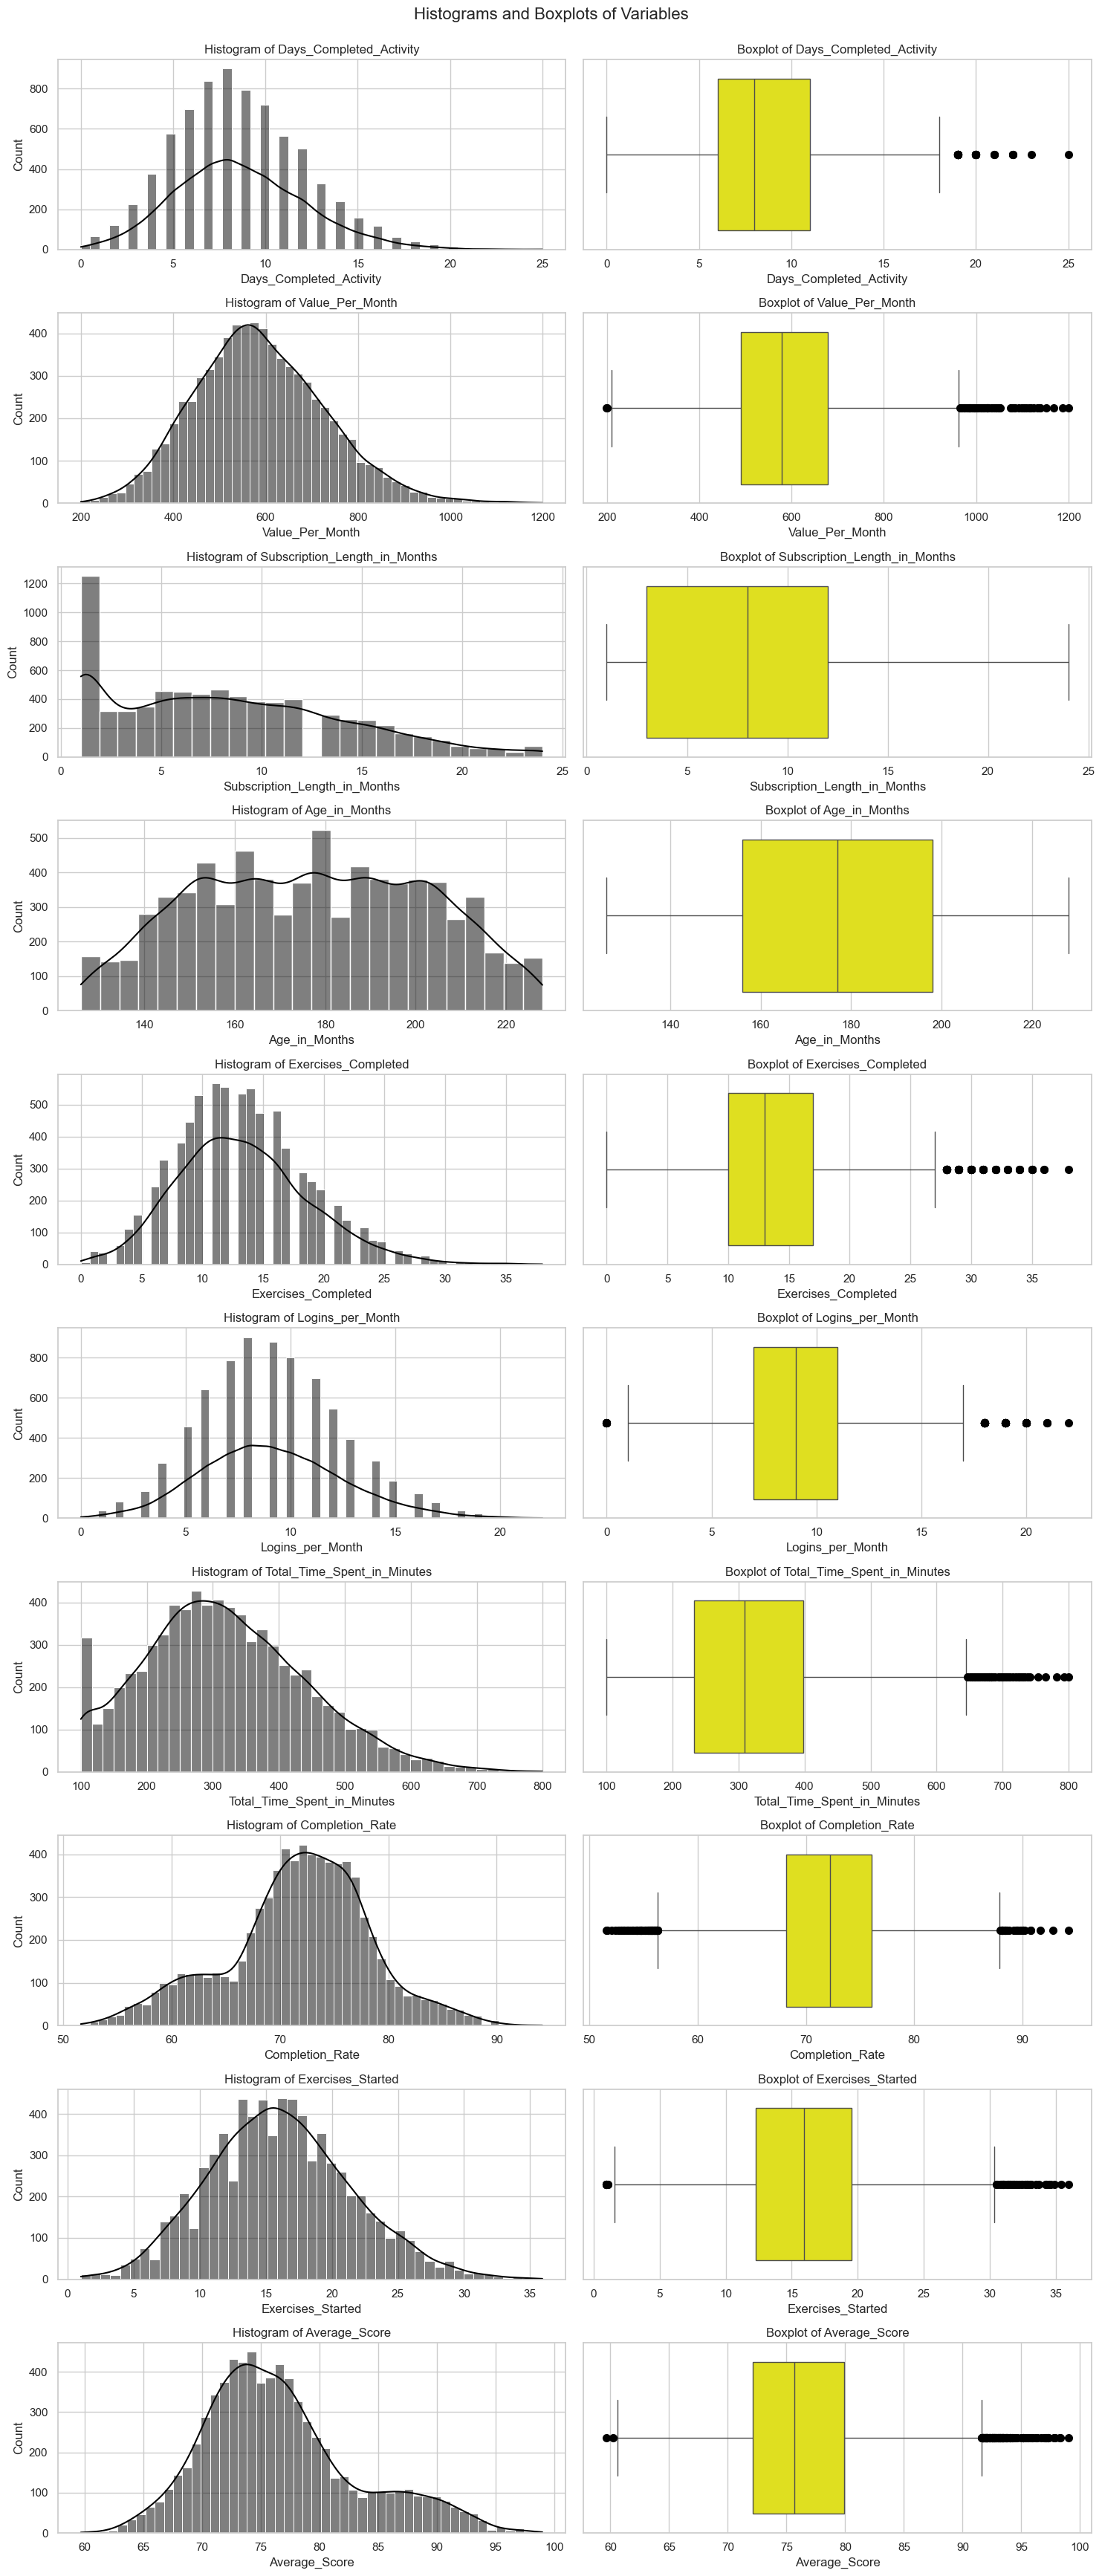

In [233]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 35))  # Adjusted for 10 pairs
fig.suptitle("Histograms and Boxplots of Variables", fontsize=16, y=0.99)
for i, column in enumerate(X.columns):
    sns.histplot(X[column], ax=axes[i, 0], kde=True, color='black')
    axes[i, 0].set_title(f'Histogram of {column}', fontsize=12)
    sns.boxplot(data=X, x=column, ax=axes[i, 1], color='yellow', fliersize=7,
                flierprops={'marker':'o', 'markerfacecolor':'black', 'markeredgecolor':'black'})
    axes[i, 1].set_title(f'Boxplot of {column}', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.97) 

In [234]:
cat = df.drop(['Days_Completed_Activity','Value_Per_Month','Subscription_Length_in_Months','Age_in_Months','Exercises_Completed',
                 'Logins_per_Month','Total_Time_Spent_in_Minutes','Completion_Rate','Exercises_Started','Average_Score'],axis = 1)

In [235]:
X_norm = X[['Subscription_Length_in_Months','Age_in_Months']]
X_norm

,Subscription_Length_in_Months,Age_in_Months
2,13,173
3,11,199
4,12,148
7,13,161
8,9,184
...,...,...
14833,2,223
14834,17,182
14839,7,127
14841,5,182


# **Removing Outliers**

In [237]:
X1 = X.drop(['Subscription_Length_in_Months','Age_in_Months','Total_Time_Spent_in_Minutes','Completion_Rate',
            'Exercises_Started','Average_Score','Value_Per_Month'],axis = 1)
z_scores = np.abs(zscore(X1))
threshold = 2.5  # Common choice is 3, but adjust as needed
X_norma = X1[(z_scores < threshold).all(axis=1)]
print(f"Original number of rows: {X1.shape[0]}")
print(f"Number of rows after removing outliers: {X_norma.shape[0]}")
X_norma

Original number of rows: 7396
Number of rows after removing outliers: 7201


,Days_Completed_Activity,Exercises_Completed,Logins_per_Month
2,4,10,7
4,8,17,10
7,6,10,7
8,9,13,8
10,3,7,5
...,...,...,...
14833,5,9,7
14834,11,22,12
14839,7,12,7
14841,9,13,7


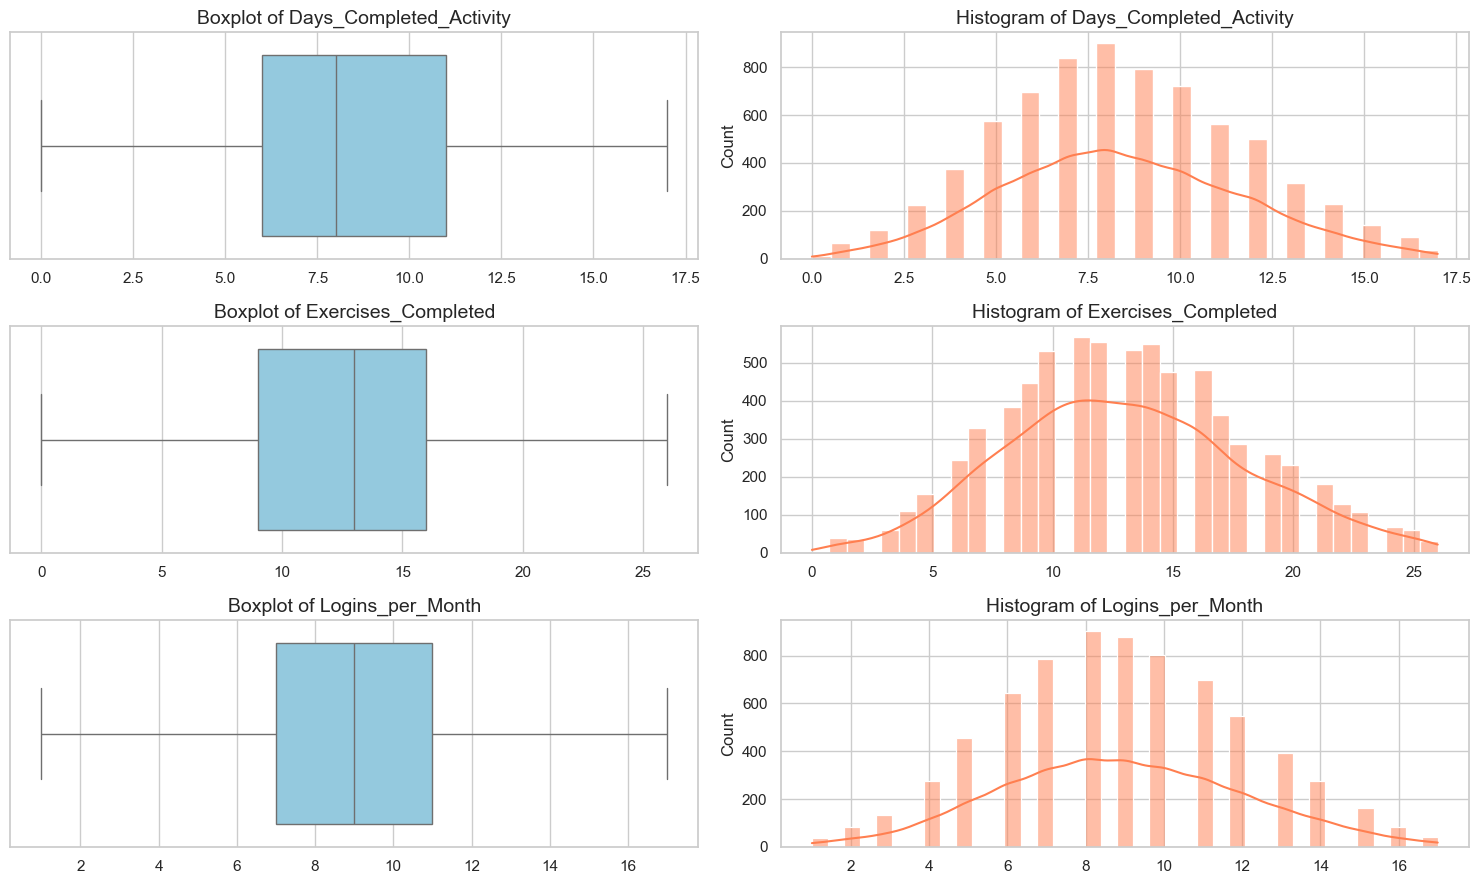

In [238]:
fig, axes = plt.subplots(nrows=len(X_norma.columns), ncols=2, figsize=(15, len(X_norma.columns) * 3))
for i, col in enumerate(X_norma.columns):
    sns.boxplot(data=X_norma, x=col, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i, 0].set_xlabel('')
    sns.histplot(data=X_norma, x=col, kde=True, ax=axes[i, 1], color="coral")
    axes[i, 1].set_title(f'Histogram of {col}', fontsize=14)
    axes[i, 1].set_xlabel('')
plt.tight_layout()
plt.show()

In [239]:
X2 = X[['Total_Time_Spent_in_Minutes','Value_Per_Month','Exercises_Started']]
z_scores = np.abs(zscore(X2))
threshold = 2.5 
X_normb = X2[(z_scores < threshold).all(axis=1)]
print(f"Original number of rows: {X2.shape[0]}")
print(f"Number of rows after removing outliers: {X_normb.shape[0]}")
X_normb

Original number of rows: 7396
Number of rows after removing outliers: 7160


,Total_Time_Spent_in_Minutes,Value_Per_Month,Exercises_Started
2,232.639784,465.073942,12.159345
4,305.275706,624.802916,15.458939
7,331.125489,632.317858,12.091814
8,347.169701,579.935470,18.024626
10,162.221141,382.636704,10.000000
...,...,...,...
14833,262.008031,596.244381,12.000000
14834,331.280997,603.126204,18.000000
14839,367.768263,543.405996,20.724994
14841,409.490339,621.517387,20.679306


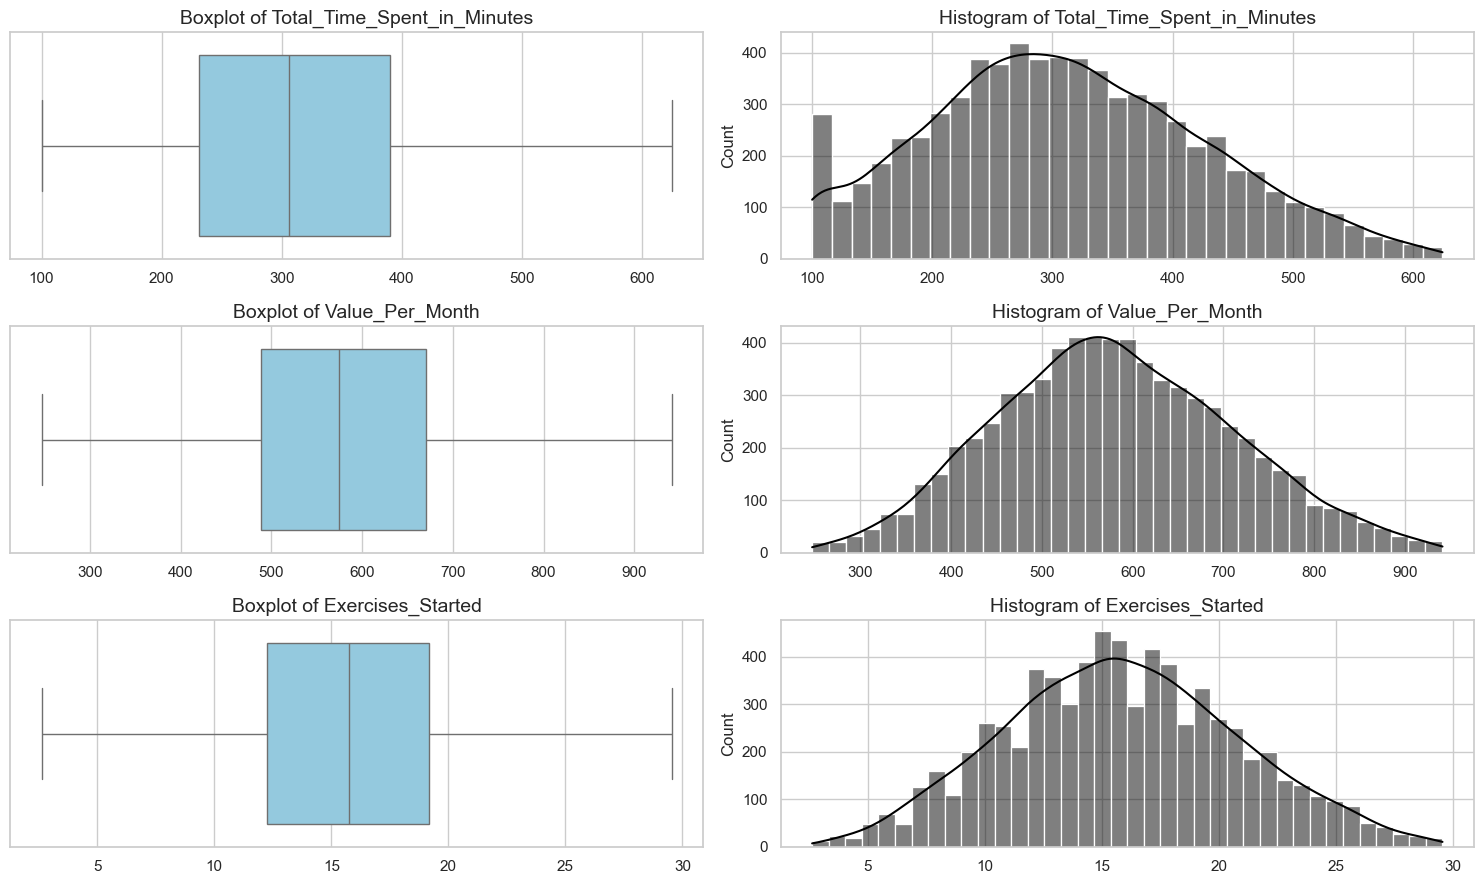

In [240]:
fig, axes = plt.subplots(nrows=len(X_normb.columns), ncols=2, figsize=(15, len(X_normb.columns) * 3))
for i, col in enumerate(X_normb.columns):
    sns.boxplot(data=X_normb, x=col, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i, 0].set_xlabel('')
    sns.histplot(data=X_normb, x=col, kde=True, ax=axes[i, 1], color="black")
    axes[i, 1].set_title(f'Histogram of {col}', fontsize=14)
    axes[i, 1].set_xlabel('')
plt.tight_layout()
plt.show()

In [241]:
X3 = X[['Completion_Rate']]
z_scores = np.abs(zscore(X3))
threshold = 2.0 
X_normc = X3[(z_scores < threshold).all(axis=1)]
print(f"Original number of rows: {X3.shape[0]}")
print(f"Number of rows after removing outliers: {X_normc.shape[0]}")
X_normc

Original number of rows: 7396
Number of rows after removing outliers: 6961


,Completion_Rate
2,73.335360
3,66.872122
4,72.236281
7,73.037686
8,70.736462
...,...
14831,79.770309
14833,62.711077
14834,69.994512
14841,69.772144


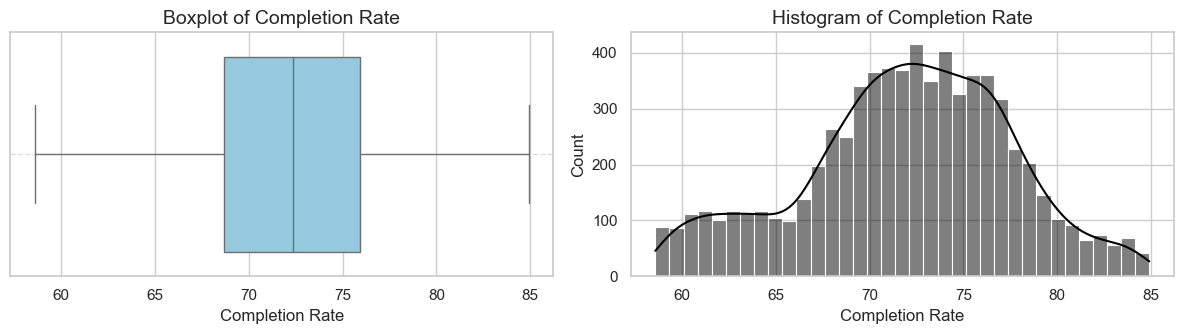

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
sns.boxplot(data=X_normc, x='Completion_Rate', ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot of Completion Rate', fontsize=14)
axes[0].set_xlabel('Completion Rate', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
sns.histplot(data=X_normc, x='Completion_Rate', kde=True, ax=axes[1], color='black')
axes[1].set_title('Histogram of Completion Rate', fontsize=14)
axes[1].set_xlabel('Completion Rate', fontsize=12)
plt.tight_layout()
plt.show()

In [243]:
X4= X[['Average_Score']]
z_scores = np.abs(zscore(X4))
threshold = 1.75 
X_normd = X4[(z_scores < threshold).all(axis=1)]
print(f"Original number of rows: {X4.shape[0]}")
print(f"Number of rows after removing outliers: {X_normd.shape[0]}")
X_normd

Original number of rows: 7396
Number of rows after removing outliers: 6706


,Average_Score
2,72.861381
3,70.912510
4,79.714467
7,77.527424
8,81.405679
...,...
14833,69.602963
14834,77.348973
14839,85.374822
14841,73.076812


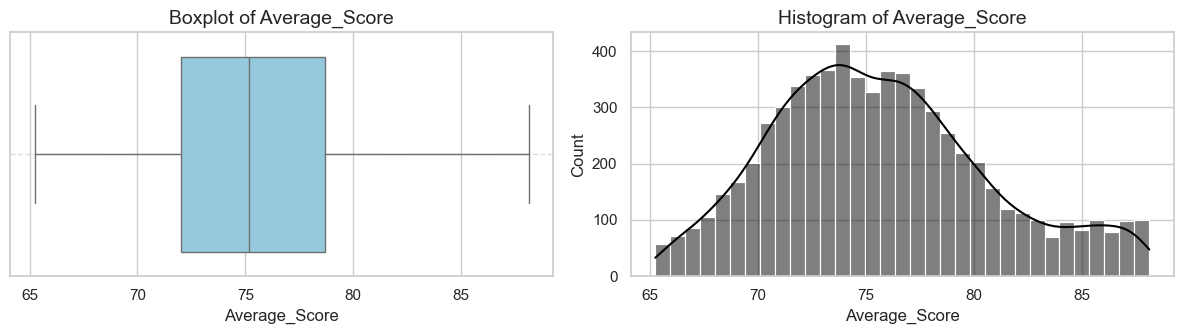

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
sns.boxplot(data=X_normd, x='Average_Score', ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot of Average_Score', fontsize=14)
axes[0].set_xlabel('Average_Score', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
sns.histplot(data=X_normd, x='Average_Score', kde=True, ax=axes[1], color='black')
axes[1].set_title('Histogram of Average_Score', fontsize=14)
axes[1].set_xlabel('Average_Score', fontsize=12)
plt.tight_layout()
plt.show()

# **BoxCox Transformation on Subscription Length in months column**

C:\Users\durga\AppData\Local\Temp\ipykernel_9064\2872782576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_norm['SLM_Adjusted'] = X_norm['Subscription_Length_in_Months'] + 1e-5
C:\Users\durga\AppData\Local\Temp\ipykernel_9064\2872782576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_norm['SLM_BoxCox_Length'], fitted_lambda = stats.boxcox(X_norm['SLM_Adjusted'])


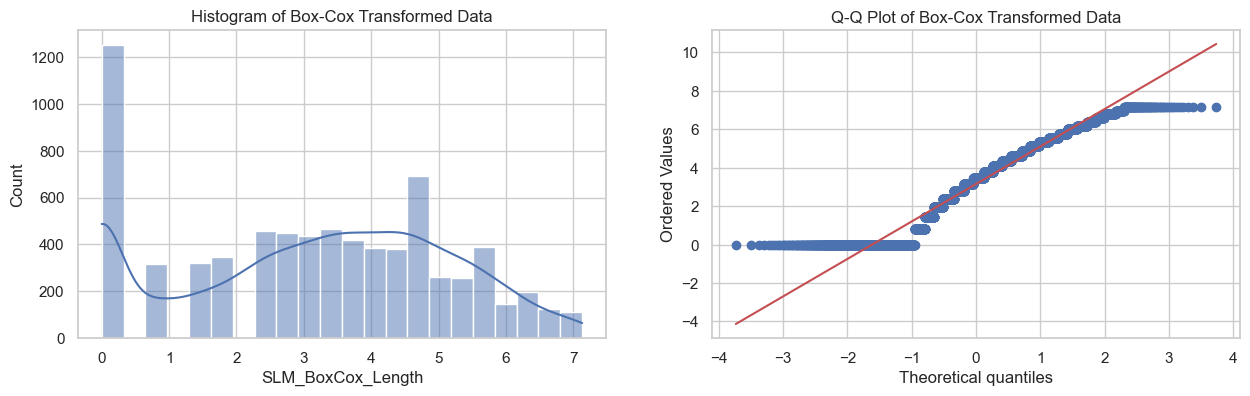

Fitted Lambda:  0.45485893923263515


In [246]:
X_norm['SLM_Adjusted'] = X_norm['Subscription_Length_in_Months'] + 1e-5
X_norm['SLM_BoxCox_Length'], fitted_lambda = stats.boxcox(X_norm['SLM_Adjusted'])
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.histplot(X_norm['SLM_BoxCox_Length'], kde=True)
plt.title('Histogram of Box-Cox Transformed Data')
plt.subplot(1, 2, 2)
stats.probplot(X_norm['SLM_BoxCox_Length'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Data')
plt.show()
print("Fitted Lambda: ", fitted_lambda)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 2))
sns.boxplot(x=X_norm['Subscription_Length_in_Months'])
plt.title('Subscription Length in Months')
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(15, 2))
sns.boxplot(x=X_norm['SLM_BoxCox_Length'])
plt.title('SLM_BoxCox_Length')
plt.show()

In [249]:
X_norm = X_norm.drop(['SLM_Adjusted','Subscription_Length_in_Months'],axis = 1)
X_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 2 to 14842
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age_in_Months      7396 non-null   int64  
 1   SLM_BoxCox_Length  7396 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 173.3 KB


# **BoxCox Transformation on Total Time Spent in Minutes column**

C:\Users\durga\AppData\Local\Temp\ipykernel_9064\3454801189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normb['TTSM_Adjusted'] =X_normb['Total_Time_Spent_in_Minutes'] + 1e-5
C:\Users\durga\AppData\Local\Temp\ipykernel_9064\3454801189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normb['TTSM_BoxCox_Length'], fitted_lambda = stats.boxcox(X_normb['TTSM_Adjusted'])


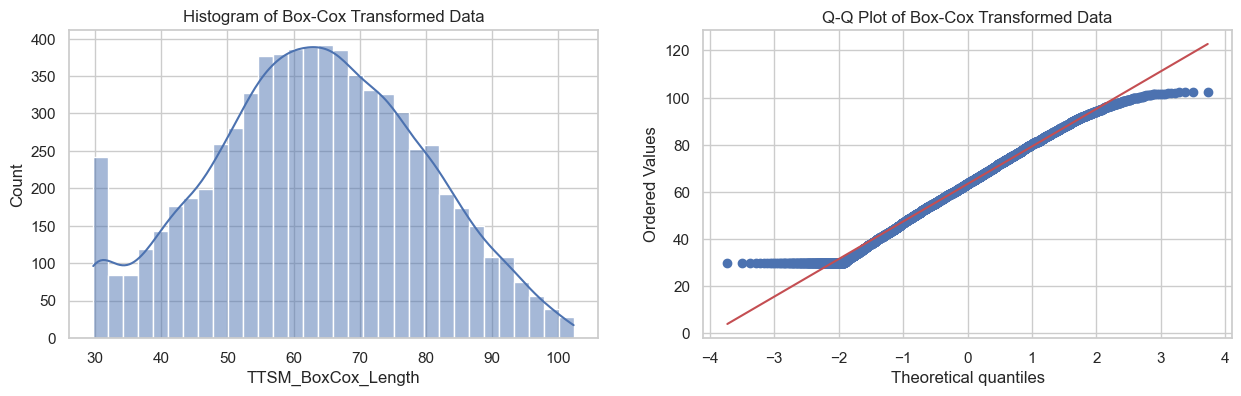

Fitted Lambda:  0.655705083658942


In [251]:
X_normb['TTSM_Adjusted'] =X_normb['Total_Time_Spent_in_Minutes'] + 1e-5
X_normb['TTSM_BoxCox_Length'], fitted_lambda = stats.boxcox(X_normb['TTSM_Adjusted'])
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.histplot(X_normb['TTSM_BoxCox_Length'], kde=True)
plt.title('Histogram of Box-Cox Transformed Data')
plt.subplot(1, 2, 2)
stats.probplot(X_normb['TTSM_BoxCox_Length'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Data')
plt.show()
print("Fitted Lambda: ", fitted_lambda)

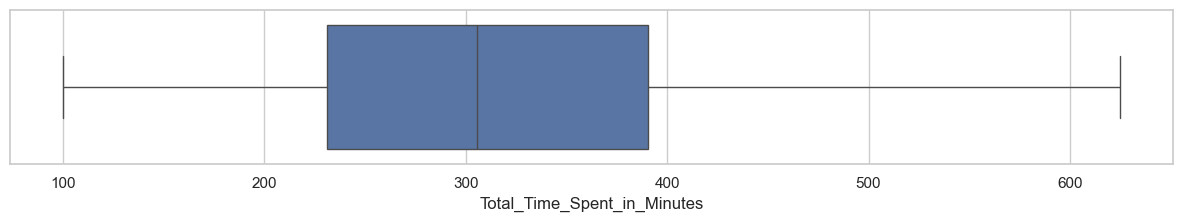

In [252]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 2))
sns.boxplot(x=X_normb['Total_Time_Spent_in_Minutes'])
plt.xlabel('Total_Time_Spent_in_Minutes')
plt.show()

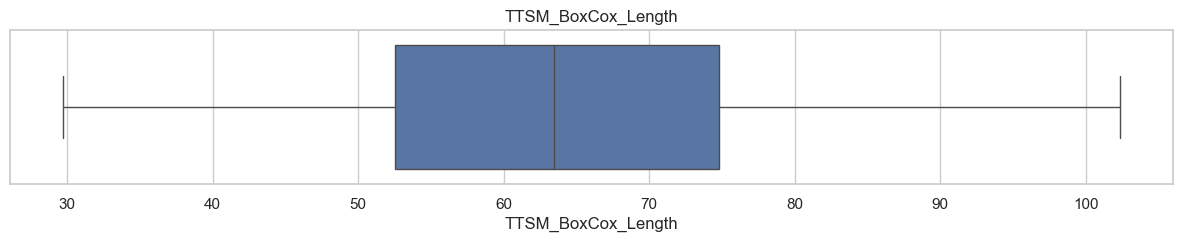

In [253]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 2))
sns.boxplot(x=X_normb['TTSM_BoxCox_Length'])
plt.title('TTSM_BoxCox_Length')
plt.show()

In [254]:
X_normb = X_normb.drop(['TTSM_Adjusted','Total_Time_Spent_in_Minutes'],axis = 1)

In [255]:
data = pd.concat([cat, X_norm, X_norma, X_normb, X_normc, X_normd], axis=1, join='outer')

In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 2 to 14842
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     7396 non-null   object 
 1   Grade                      7396 non-null   object 
 2   Course_Category            7396 non-null   object 
 3   Course_Rating              7396 non-null   int64  
 4   Recommendation_Likelihood  7396 non-null   int64  
 5   Subscription_Tier          7396 non-null   object 
 6   Renewal_Status             7396 non-null   object 
 7   Tutoring                   7396 non-null   object 
 8   Referrals                  7396 non-null   int64  
 9   Academic_Grade             7396 non-null   object 
 10  Age_in_Months              7396 non-null   int64  
 11  SLM_BoxCox_Length          7396 non-null   float64
 12  Days_Completed_Activity    7201 non-null   float64
 13  Exercises_Completed        7201 non-null   float64
 

# **Missing Values**

In [258]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Gender                       0.000000
Grade                        0.000000
Course_Category              0.000000
Course_Rating                0.000000
Recommendation_Likelihood    0.000000
Subscription_Tier            0.000000
Renewal_Status               0.000000
Tutoring                     0.000000
Referrals                    0.000000
Academic_Grade               0.000000
Age_in_Months                0.000000
SLM_BoxCox_Length            0.000000
Days_Completed_Activity      2.636560
Exercises_Completed          2.636560
Logins_per_Month             2.636560
Value_Per_Month              3.190914
Exercises_Started            3.190914
TTSM_BoxCox_Length           3.190914
Completion_Rate              5.881558
Average_Score                9.329367
dtype: float64


# **Removing Missing Values**

In [260]:
impdata = data.dropna()
impdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6112 entries, 2 to 14842
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     6112 non-null   object 
 1   Grade                      6112 non-null   object 
 2   Course_Category            6112 non-null   object 
 3   Course_Rating              6112 non-null   int64  
 4   Recommendation_Likelihood  6112 non-null   int64  
 5   Subscription_Tier          6112 non-null   object 
 6   Renewal_Status             6112 non-null   object 
 7   Tutoring                   6112 non-null   object 
 8   Referrals                  6112 non-null   int64  
 9   Academic_Grade             6112 non-null   object 
 10  Age_in_Months              6112 non-null   int64  
 11  SLM_BoxCox_Length          6112 non-null   float64
 12  Days_Completed_Activity    6112 non-null   float64
 13  Exercises_Completed        6112 non-null   float64
 

In [261]:
impdata.describe()

,Course_Rating,Recommendation_Likelihood,Referrals,Age_in_Months,SLM_BoxCox_Length,Days_Completed_Activity,Exercises_Completed,Logins_per_Month,Value_Per_Month,Exercises_Started,TTSM_BoxCox_Length,Completion_Rate,Average_Score
count,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000
mean,4.064463,3.572644,0.411813,176.139725,3.139705,8.366001,12.901014,8.868946,576.158612,15.663903,62.881226,71.488927,75.643339
std,0.358318,0.620089,0.703041,25.213890,2.010449,3.182659,4.802653,3.038832,127.774005,4.891644,15.711592,5.259877,4.891246
min,3.000000,2.000000,0.000000,126.000000,0.000010,0.000000,1.000000,1.000000,249.832716,2.621327,29.714249,58.580811,65.301672
25%,4.000000,3.000000,0.000000,155.000000,1.425171,6.000000,9.000000,7.000000,485.693801,12.129888,52.353322,68.429014,72.140642
50%,4.000000,4.000000,0.000000,176.000000,3.462632,8.000000,13.000000,9.000000,571.221850,15.613276,63.038783,71.960128,75.166069
75%,4.000000,4.000000,1.000000,197.000000,4.609189,11.000000,16.000000,11.000000,663.162403,19.000000,74.104465,75.315918,78.565039
max,5.000000,5.000000,3.000000,228.000000,7.132443,17.000000,26.000000,17.000000,941.354124,29.447745,102.268918,84.913992,88.140005


# **Heatmap**

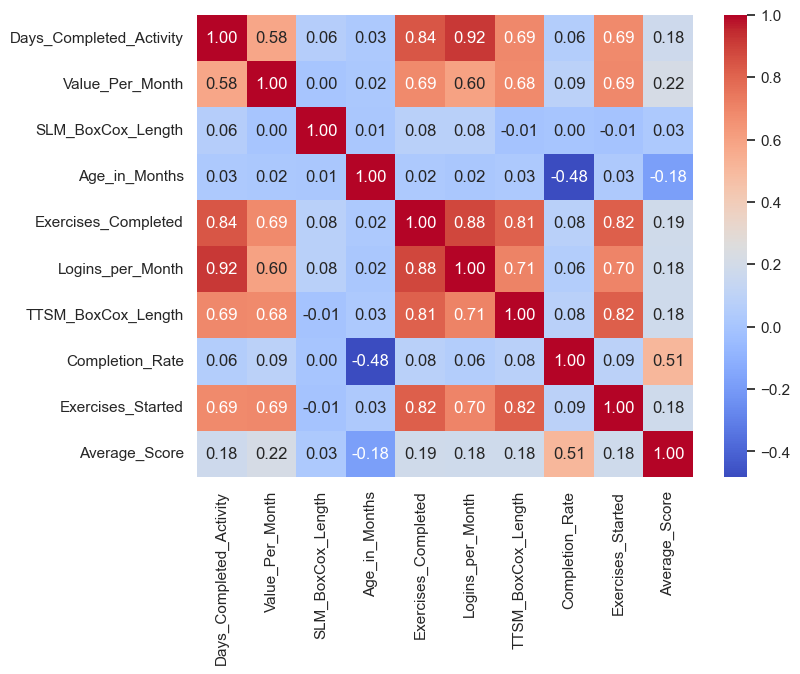

In [263]:
corr_mat = impdata[['Days_Completed_Activity','Value_Per_Month','SLM_BoxCox_Length','Age_in_Months','Exercises_Completed',
                 'Logins_per_Month','TTSM_BoxCox_Length','Completion_Rate','Exercises_Started','Average_Score']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# **Data Segmentation using K-Means**

In [265]:
clu_data = impdata.copy()
data = impdata.drop(['Grade','Gender','Academic_Grade','Renewal_Status','Subscription_Tier','Course_Rating'],axis = 1)

# One Hot Encoding

In [267]:
ohe = pd.get_dummies(data, columns=['Course_Category','Tutoring'],  dtype=bool)
ohe = ohe.astype(int)

data = ohe.rename(columns={
    'Course_Category_Math': 'Math',
    'Course_Category_Programming': 'Programming',
    'Course_Category_Science': 'Science'
})

b = data[['Math','Programming','Science','Tutoring_No','Tutoring_Yes']].reset_index(drop=True)
b

,Math,Programming,Science,Tutoring_No,Tutoring_Yes
0,1,0,0,1,0
1,0,1,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,0,0,1,0
...,...,...,...,...,...
6107,1,0,0,0,1
6108,0,1,0,1,0
6109,1,0,0,1,0
6110,1,0,0,1,0


# Standardizing

In [269]:
scale = StandardScaler()
data = pd.DataFrame(scale.fit_transform(data),columns = data.columns)
data

,Recommendation_Likelihood,Referrals,Age_in_Months,SLM_BoxCox_Length,Days_Completed_Activity,Exercises_Completed,Logins_per_Month,Value_Per_Month,Exercises_Started,TTSM_BoxCox_Length,Completion_Rate,Average_Score,Math,Programming,Science,Tutoring_No,Tutoring_Yes
0,0.689241,-0.585807,-0.124534,0.670831,-1.371922,-0.604094,-0.615072,-0.866117,-0.677799,-0.659658,0.379909,-0.641093,1.426977,-0.717720,-0.702859,0.394469,-0.394469
1,0.689241,-0.585807,-1.116132,0.670831,-0.115008,0.853553,0.372231,0.378362,-0.058776,0.039749,0.190156,0.787996,-0.700782,1.393302,-0.702859,0.394469,-0.394469
2,0.689241,0.836701,-0.600501,0.670831,-0.743465,-0.604094,-0.615072,0.440977,-0.677799,0.230497,0.379909,0.379685,1.426977,-0.717720,-0.702859,0.394469,-0.394469
3,-0.923562,2.259208,0.311769,0.150247,0.199220,0.020612,-0.285971,0.026151,0.560247,0.421244,-0.189349,1.196308,1.426977,-0.717720,-0.702859,0.394469,-0.394469
4,0.689241,0.836701,0.391097,-0.890920,-1.686150,-1.228799,-1.273273,-1.515751,-1.090481,-1.359065,0.000404,-0.845248,1.426977,-0.717720,-0.702859,0.394469,-0.394469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6107,2.302043,-0.585807,-1.155796,-1.411504,0.199220,0.645318,0.372231,-0.286926,0.766588,0.548409,1.518426,2.012930,1.426977,-0.717720,-0.702859,-2.535052,2.535052
6108,0.689241,2.259208,1.858662,-1.411504,-1.057693,-0.812329,-0.615072,0.159208,-0.677799,-0.341746,-1.707371,-1.253559,-0.700782,1.393302,-0.702859,0.394469,-0.394469
6109,-0.923562,2.259208,0.232441,1.191414,0.827677,1.894730,1.030432,0.213997,0.560247,0.230497,-0.379102,0.379685,1.426977,-0.717720,-0.702859,0.394469,-0.394469
6110,0.689241,-0.585807,0.232441,-0.370337,0.199220,0.020612,-0.615072,0.354881,0.972929,0.929904,-0.379102,-0.436937,1.426977,-0.717720,-0.702859,0.394469,-0.394469


In [270]:
variances = data.var()
average_variance = variances.mean()
print("Average Variance:", average_variance)

Average Variance: 1.0001636393389104


# Principal Component Analysis

In [272]:
pca = PCA(n_components=2)
res_pca = pca.fit_transform(data)

# Elbow Plot

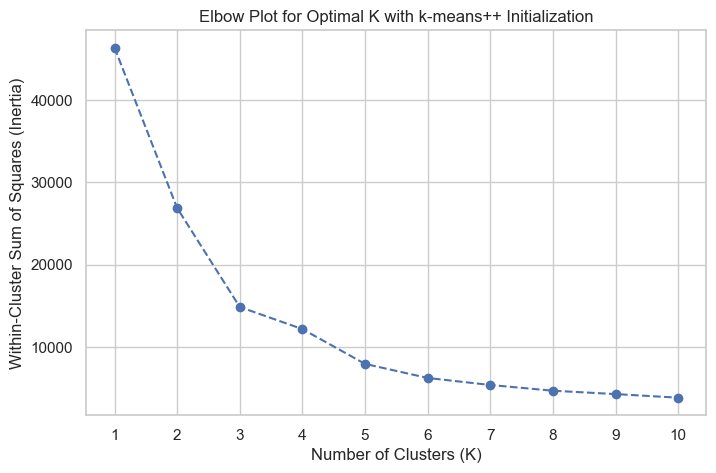

In [274]:
# List to store the sum of squared distances for different K values
inertia = []

# Range of K values to testa
K_range = range(1, 11)

# Calculate the inertia for each K using k-means++ initialization
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(res_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.xticks(range(1,11,1))
plt.title('Elbow Plot for Optimal K with k-means++ Initialization')
plt.show()

# Radial Basis Function Kernel PCA

In [276]:
variances = data.var()
average_variance = variances.mean()
print("Average Variance:", average_variance)
gamma = 1/average_variance
print("gamma : ",gamma)

Average Variance: 1.0001636393389104
gamma :  0.9998363874345416


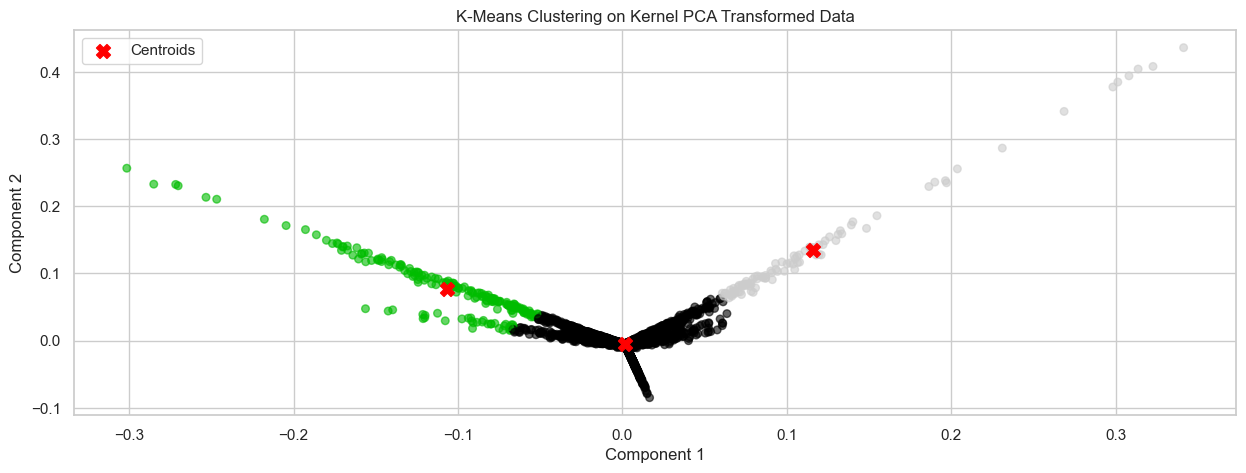

Silhouette Score: 0.8674325568624711


In [277]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1)
res_kpca_rbf = kpca.fit_transform(data)
rbf_df = pd.DataFrame(res_kpca_rbf, columns=['PCA1', 'PCA2'])
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)  # Corrected 'init' parameter
kmeans.fit(res_kpca_rbf)
rbf_labels = kmeans.labels_
plt.figure(figsize=(15, 5))
plt.scatter(res_kpca_rbf[:, 0], res_kpca_rbf[:, 1], c=rbf_labels, cmap='nipy_spectral', s=30, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=100, label='Centroids')
plt.title('K-Means Clustering on Kernel PCA Transformed Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()
sil_score = silhouette_score(res_kpca_rbf, rbf_labels)
print(f'Silhouette Score: {sil_score}')

# Cluster Assignment

In [279]:
clu_data = clu_data.reset_index(drop=True)
clu_data['Cluster'] = rbf_labels  # Add cluster labels to the DataFrame

# Reorder columns to put 'Cluster' first
columns = ['Cluster'] + [col for col in clu_data.columns if col != 'Cluster']
clu_data = clu_data[columns]
clu_data


,Cluster,Gender,Grade,Course_Category,Course_Rating,Recommendation_Likelihood,Subscription_Tier,Renewal_Status,Tutoring,Referrals,...,Age_in_Months,SLM_BoxCox_Length,Days_Completed_Activity,Exercises_Completed,Logins_per_Month,Value_Per_Month,Exercises_Started,TTSM_BoxCox_Length,Completion_Rate,Average_Score
0,0,Other,9th Grade,Math,4,4,Premium,Yes,No,0,...,173,4.861611,4.0,10.0,7.0,465.073942,12.159345,52.817245,73.335360,72.861381
1,2,Female,7th Grade,Programming,4,4,Premium,Yes,No,0,...,148,4.609189,8.0,17.0,10.0,624.802916,15.458939,63.415599,72.236281,79.714467
2,0,Female,7th Grade,Math,4,4,Premium,Yes,No,1,...,161,4.861611,6.0,10.0,7.0,632.317858,12.091814,66.970642,73.037686,77.527424
3,0,Male,9th Grade,Math,4,3,Basic,Yes,No,2,...,184,3.774196,9.0,13.0,8.0,579.935470,18.024626,69.129068,70.736462,81.405679
4,0,Male,10th Grade,Math,4,4,Basic,Yes,No,1,...,186,1.425171,3.0,7.0,5.0,382.636704,10.000000,41.376195,71.524383,71.402166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6107,0,Female,6th Grade,Math,5,5,Basic,Yes,Yes,0,...,147,0.000010,9.0,16.0,10.0,539.604378,19.341885,71.988751,79.770309,85.884324
6108,0,Other,12th Grade,Programming,4,4,Basic,Yes,No,2,...,223,0.814872,5.0,9.0,7.0,596.244381,12.000000,57.222864,62.711077,69.602963
6109,0,Other,10th Grade,Math,4,3,Premium,No,No,2,...,182,5.777864,11.0,22.0,12.0,603.126204,18.000000,66.991733,69.994512,77.348973
6110,0,Male,10th Grade,Math,4,4,Basic,Yes,No,0,...,182,2.372992,9.0,13.0,7.0,621.517387,20.679306,77.207218,69.772144,73.076812


# Cluster Distribution

In [281]:
f = clu_data['Cluster'].value_counts()
f = pd.DataFrame(f)
f

,count
Cluster,
0,5825
1,192
2,95


In [282]:
file_path = r'C:\Users\durga\OneDrive\Desktop\hanuman\clu_data.csv'
clu_data.to_csv(file_path, index=False)

# **Machine Learning Model Building**

In [284]:
impdata

,Gender,Grade,Course_Category,Course_Rating,Recommendation_Likelihood,Subscription_Tier,Renewal_Status,Tutoring,Referrals,Academic_Grade,Age_in_Months,SLM_BoxCox_Length,Days_Completed_Activity,Exercises_Completed,Logins_per_Month,Value_Per_Month,Exercises_Started,TTSM_BoxCox_Length,Completion_Rate,Average_Score
2,Other,9th Grade,Math,4,4,Premium,Yes,No,0,D,173,4.861611,4.0,10.0,7.0,465.073942,12.159345,52.817245,73.335360,72.861381
4,Female,7th Grade,Programming,4,4,Premium,Yes,No,0,F,148,4.609189,8.0,17.0,10.0,624.802916,15.458939,63.415599,72.236281,79.714467
7,Female,7th Grade,Math,4,4,Premium,Yes,No,1,F,161,4.861611,6.0,10.0,7.0,632.317858,12.091814,66.970642,73.037686,77.527424
8,Male,9th Grade,Math,4,3,Basic,Yes,No,2,D,184,3.774196,9.0,13.0,8.0,579.935470,18.024626,69.129068,70.736462,81.405679
10,Male,10th Grade,Math,4,4,Basic,Yes,No,1,F,186,1.425171,3.0,7.0,5.0,382.636704,10.000000,41.376195,71.524383,71.402166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14831,Female,6th Grade,Math,5,5,Basic,Yes,Yes,0,D,147,0.000010,9.0,16.0,10.0,539.604378,19.341885,71.988751,79.770309,85.884324
14833,Other,12th Grade,Programming,4,4,Basic,Yes,No,2,F,223,0.814872,5.0,9.0,7.0,596.244381,12.000000,57.222864,62.711077,69.602963
14834,Other,10th Grade,Math,4,3,Premium,No,No,2,F,182,5.777864,11.0,22.0,12.0,603.126204,18.000000,66.991733,69.994512,77.348973
14841,Male,10th Grade,Math,4,4,Basic,Yes,No,0,F,182,2.372992,9.0,13.0,7.0,621.517387,20.679306,77.207218,69.772144,73.076812


In [285]:
a = impdata.drop(['Gender','Grade','Academic_Grade','Tutoring','Course_Rating',
                  'Subscription_Tier','Renewal_Status','Course_Category'],axis = 1)

# Feature Set

In [287]:
a = pd.DataFrame(scale.fit_transform(a),columns = a.columns)
a

,Recommendation_Likelihood,Referrals,Age_in_Months,SLM_BoxCox_Length,Days_Completed_Activity,Exercises_Completed,Logins_per_Month,Value_Per_Month,Exercises_Started,TTSM_BoxCox_Length,Completion_Rate,Average_Score
0,0.689241,-0.585807,-0.124534,0.856548,-1.371922,-0.604094,-0.615072,-0.869455,-0.716496,-0.640597,0.351070,-0.568809
1,0.689241,-0.585807,-1.116132,0.730983,-0.115008,0.853553,0.372231,0.380737,-0.041904,0.034014,0.142097,0.832398
2,0.689241,0.836701,-0.600501,0.856548,-0.743465,-0.604094,-0.615072,0.439556,-0.730303,0.260301,0.294472,0.385227
3,-0.923562,2.259208,0.311769,0.315622,0.199220,0.020612,-0.285971,0.029561,0.482643,0.397691,-0.143069,1.178189
4,0.689241,0.836701,0.391097,-0.852881,-1.686150,-1.228799,-1.273273,-1.514688,-1.157968,-1.368849,0.006741,-0.867166
...,...,...,...,...,...,...,...,...,...,...,...,...
6107,2.302043,-0.585807,-1.155796,-1.561816,0.199220,0.645318,0.372231,-0.286108,0.751952,0.579717,1.574573,2.093909
6108,0.689241,2.259208,1.858662,-1.156469,-1.057693,-0.812329,-0.615072,0.157210,-0.749074,-0.360169,-1.668968,-1.235037
6109,-0.923562,2.259208,0.232441,1.312331,0.827677,1.894730,1.030432,0.211074,0.477608,0.261644,-0.284139,0.348740
6110,0.689241,-0.585807,0.232441,-0.381395,0.199220,0.020612,-0.615072,0.355021,1.025384,0.911885,-0.326419,-0.524761


# Label Encoding

In [289]:
# Encode target labels
y = impdata['Subscription_Tier']
le = LabelEncoder()
y = le.fit_transform(y)

In [290]:
y_df = pd.DataFrame(y, columns=['Subscription_Tier'])
pd.DataFrame(y_df.value_counts())

,count
Subscription_Tier,
0,3720
1,2392


In [291]:
X = a[['Days_Completed_Activity','Value_Per_Month','SLM_BoxCox_Length','Age_in_Months','Exercises_Completed',
        'Logins_per_Month','TTSM_BoxCox_Length','Exercises_Started','Referrals',
       'Recommendation_Likelihood']]
Xx = pd.concat([b,X],axis = 1)
Xx

,Math,Programming,Science,Tutoring_No,Tutoring_Yes,Days_Completed_Activity,Value_Per_Month,SLM_BoxCox_Length,Age_in_Months,Exercises_Completed,Logins_per_Month,TTSM_BoxCox_Length,Exercises_Started,Referrals,Recommendation_Likelihood
0,1,0,0,1,0,-1.371922,-0.869455,0.856548,-0.124534,-0.604094,-0.615072,-0.640597,-0.716496,-0.585807,0.689241
1,0,1,0,1,0,-0.115008,0.380737,0.730983,-1.116132,0.853553,0.372231,0.034014,-0.041904,-0.585807,0.689241
2,1,0,0,1,0,-0.743465,0.439556,0.856548,-0.600501,-0.604094,-0.615072,0.260301,-0.730303,0.836701,0.689241
3,1,0,0,1,0,0.199220,0.029561,0.315622,0.311769,0.020612,-0.285971,0.397691,0.482643,2.259208,-0.923562
4,1,0,0,1,0,-1.686150,-1.514688,-0.852881,0.391097,-1.228799,-1.273273,-1.368849,-1.157968,0.836701,0.689241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6107,1,0,0,0,1,0.199220,-0.286108,-1.561816,-1.155796,0.645318,0.372231,0.579717,0.751952,-0.585807,2.302043
6108,0,1,0,1,0,-1.057693,0.157210,-1.156469,1.858662,-0.812329,-0.615072,-0.360169,-0.749074,2.259208,0.689241
6109,1,0,0,1,0,0.827677,0.211074,1.312331,0.232441,1.894730,1.030432,0.261644,0.477608,2.259208,-0.923562
6110,1,0,0,1,0,0.199220,0.355021,-0.381395,0.232441,0.020612,-0.615072,0.911885,1.025384,-0.585807,0.689241


# Splitting the data into Training and Testing data

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(Xx,y,test_size = 0.20,random_state = 42)

# **Model Building**

# Data Preparation

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class Imbalance Handling

In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)



# Cross Validation & OOF Framework

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# OOF predictions
oof_xgb = np.zeros(len(X_train))
oof_nn = np.zeros(len(X_train))

test_xgb = np.zeros(len(X_test))
test_nn = np.zeros(len(X_test))

# PyTorch MLP (Deep Model)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

    print(f"\n===== FOLD {fold+1} =====")

    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    X_tr_scaled = X_train_scaled[train_idx]
    X_val_scaled = X_train_scaled[val_idx]

# XG Boost (Tree Model)

In [ ]:
    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",
        random_state=42,
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    )

    xgb_model.fit(X_tr, y_tr)

    oof_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]
    test_xgb += xgb_model.predict_proba(X_test)[:, 1] / n_splits


# Neural Network pipeline

In [ ]:
model = MLP(X_train.shape[1]).to(device)

pos_weight = torch.tensor([scale_pos_weight * 0.9], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

X_tr_t = torch.tensor(X_tr_scaled, dtype=torch.float32).to(device)
y_tr_t = torch.tensor(y_tr, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)

epochs = 25
batch_size = 256

for epoch in range(epochs):

        model.train()
        perm = torch.randperm(X_tr_t.size(0))

        for i in range(0, X_tr_t.size(0), batch_size):

            idx = perm[i:i + batch_size]
            xb = X_tr_t[idx]
            yb = y_tr_t[idx]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

model.eval()
with torch.no_grad():
        oof_nn[val_idx] = torch.sigmoid(model(X_val_t)).cpu().numpy()

        X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        test_nn += torch.sigmoid(model(X_test_t)).cpu().numpy() / n_splits

# Logistic Regression

In [ ]:
stack_train = np.vstack([oof_xgb, oof_nn]).T
stack_test = np.vstack([test_xgb, test_nn]).T

meta_model = LogisticRegression()
meta_model.fit(stack_train, y_train)

final_prob = meta_model.predict_proba(stack_test)[:, 1]

# Threshold Optimization

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, final_prob)

f1 = 2 * precision * recall / (precision + recall + 1e-9)

best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)

# Final Evaluation

In [ ]:
y_pred = (final_prob >= best_threshold).astype(int)

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, final_prob))
print("AUPRC:", auc(recall, precision))